In [1]:
!pip install rdkit
!pip install deepchem
!pip install pysmiles
!pip install networkx
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.9 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=c50ebe76a98bd861da559b4d923d48d298b87a974b25e084b7c48de5a1d6069e
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [2]:
import deepchem as dc
from rdkit import Chem
from deepchem.feat.mol_graphs import ConvMol
from pysmiles import read_smiles
import mordred

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
# NR-XXX -> Nuclear Receptor
# SR-XXX -> Stress Response

'''
Each task represents a quality of cellular biology and biochemistry

['NR-AR',           Androgen Receptor
 'NR-AR-LBD',       Androgen Receptor Ligand Binding Domain
 'NR-AhR',          Aryl Hydrocarbon Receptor (response to environmental toxins)
 'NR-Aromatase',    Aromatase (enzyme that converts androgens to estrogens)
 'NR-ER',           Estrogen Receptor
 'NR-ER-LBD',       Estrogen Receptor Ligand Binding Domain
 'NR-PPAR-gamma',   Peroxisome Proliferator-Activated Receptor Gamm (fat storage and glucose)

 'SR-ARE',          Antioxidant Response Element
 'SR-ATAD5',        The ATAD5 gene is involved in DNA damage response (could lead to mutations)
 'SR-HSE',          Heat Shock Element (initiate heat shock responses)
 'SR-MMP',          Matrix Metalloproteinase (potential carcinogenic effects)
 'SR-p53']          p53 is a crucial tumor suppressor
 '''

#tasks are the 12 axis each chemical may fall into
# a molecule can be multiple classifications


"\nEach task represents a quality of cellular biology and biochemistry\n\n['NR-AR',           Androgen Receptor\n 'NR-AR-LBD',       Androgen Receptor Ligand Binding Domain\n 'NR-AhR',          Aryl Hydrocarbon Receptor (response to environmental toxins)\n 'NR-Aromatase',    Aromatase (enzyme that converts androgens to estrogens)\n 'NR-ER',           Estrogen Receptor\n 'NR-ER-LBD',       Estrogen Receptor Ligand Binding Domain\n 'NR-PPAR-gamma',   Peroxisome Proliferator-Activated Receptor Gamm (fat storage and glucose)\n\n 'SR-ARE',          Antioxidant Response Element\n 'SR-ATAD5',        The ATAD5 gene is involved in DNA damage response (could lead to mutations)\n 'SR-HSE',          Heat Shock Element (initiate heat shock responses)\n 'SR-MMP',          Matrix Metalloproteinase (potential carcinogenic effects)\n 'SR-p53']          p53 is a crucial tumor suppressor\n "

# **Using Modred to Descriptors to Featurize Molecules**

For Information on how I did this and thereafter trimmed the dataset, please
look at the full unclean notebook

# **Building the model**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [6]:
data = pd.read_csv('tox21_dataset.csv')

In [7]:
data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,...,JGI1,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,0,0,1,0,0,0,0,1,0,0,...,0.294118,0.080000,0.047033,0.065741,0.030258,0.034970,0.022428,0.018519,0.000000,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0.156250,0.090909,0.077336,0.040340,0.028333,0.015334,0.017795,0.020408,0.000000,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,0.208333,0.128655,0.058554,0.047859,0.032558,0.026715,0.020712,0.012766,0.010313,0.012346
3,0,0,0,0,0,0,0,0,0,0,...,0.200000,0.111111,0.060417,0.043218,0.022500,0.021380,0.012336,0.010408,0.006875,0.012346
4,0,0,0,0,0,0,0,0,0,0,...,0.600000,0.185185,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Get working on one feature

In [8]:
TOX21_TASKS = ['NR-AR']
task_data = data.iloc[:, 0:1]
feature_data = data.iloc[:, 14:]

In [9]:
# normalize data
object= StandardScaler()
scale = object.fit_transform(feature_data)

In [10]:
feature_data.head()

,nAcid,nBase,nAromAtom,nAtom,nSpiro,nBridgehead,nHetero,nB,nN,nO,...,JGI1,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10
0,0,0,9,26,0,0,7,0,2,3,...,0.294118,0.080000,0.047033,0.065741,0.030258,0.034970,0.022428,0.018519,0.000000,0.000000
1,0,0,6,27,0,0,4,0,2,2,...,0.156250,0.090909,0.077336,0.040340,0.028333,0.015334,0.017795,0.020408,0.000000,0.000000
2,0,0,0,53,0,0,1,0,0,1,...,0.208333,0.128655,0.058554,0.047859,0.032558,0.026715,0.020712,0.012766,0.010313,0.012346
3,0,1,6,48,0,0,3,0,2,1,...,0.200000,0.111111,0.060417,0.043218,0.022500,0.021380,0.012336,0.010408,0.006875,0.012346
4,4,0,0,19,0,0,9,0,0,7,...,0.600000,0.185185,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
print(task_data.shape)
print(feature_data.shape)
#split the data into training and test data
features_train, features_test, task_train, task_test = train_test_split(feature_data, task_data, test_size=0.20, random_state=42)

(7831, 1)
(7831, 226)


In [13]:
task_train.value_counts()

,count
NR-AR,
0,6016
1,248


In [12]:
# compute sample weights
sample_weight = []
for x, item in enumerate(task_train["NR-AR"]):
  if item == 0:
    sample_weight.append(1)
  if item == 1:
    sample_weight.append(2)

sample_weight = np.array(sample_weight)
print(sample_weight)

[1 1 1 ... 1 1 1]


In [14]:
def calculate_class_weights(y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

# y contains the class labels (0s and 1s) for the binary classification problem
class_weights = calculate_class_weights(task_train)
print("Class weights:", class_weights)

Class weights: {0: 0.5206117021276596, 1: 12.629032258064516}


In [15]:
features_train = np.array(features_train)
task_train = np.array(task_train)

features_test = np.array(features_test)
task_test = np.array(task_test)

print(type(features_train), features_train.shape)
print(type(task_train), task_train.shape)

<class 'numpy.ndarray'> (6264, 226)
<class 'numpy.ndarray'> (6264, 1)


In [16]:
def design_model(features):
    model = Sequential(name="Model")
    num_features = features.shape[1]

    #inputs (266 features)
    my_input = InputLayer(shape=(num_features,))
    model.add(my_input)

    #Hidden layers
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.42))  # Prevent overfitting (42 - the meaning of life)
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation='sigmoid', name='output')) # for 1 tasks

    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',  metrics=["AUC", "f1_score"], optimizer=opt) #loss='mse',  metrics=['mae'], optimizer=opt) #mcc -> accuracy?
    # trying mcc here
    # F1Score(num_classes=1, average='micro')
    # 'AUC', 'Recall', 'Precision'

    return model


In [17]:
# Build the model
model = design_model(feature_data)

In [18]:
model = design_model(features_train)
print(model.layers)

print(model.summary())

[<Dense name=dense_2, built=True>, <Dropout name=dropout_1, built=True>, <Dense name=dense_3, built=True>, <Dense name=output, built=True>]


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 64)                  │          14,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
history = model.fit(features_train,
                    task_train,
                    epochs=250,
                    batch_size=1,
                    verbose=1,
                    validation_split=0.4,
                    class_weight=class_weights)

# validation_split: Reserves a fraction of the training data to evaluate the model's performance on unseen data during training.
# Helps monitor overfitting and tune hyperparameters without using the test set.

Epoch 1/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - AUC: 0.5954 - f1_score: 0.1152 - loss: 46.1830 - val_AUC: 0.6218 - val_f1_score: 0.0690 - val_loss: 17.1821
Epoch 2/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.6213 - f1_score: 0.0907 - loss: 11.1302 - val_AUC: 0.7131 - val_f1_score: 0.0672 - val_loss: 2.0387
Epoch 3/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - AUC: 0.6345 - f1_score: 0.0759 - loss: 3.2871 - val_AUC: 0.4923 - val_f1_score: 0.0656 - val_loss: 0.7378
Epoch 4/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - AUC: 0.5969 - f1_score: 0.0877 - loss: 1.2668 - val_AUC: 0.6793 - val_f1_score: 0.0657 - val_loss: 0.3688
Epoch 5/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - AUC: 0.6040 - f1_score: 0.0862 - loss: 1.0598 - val_AUC: 0.6666 - val_f1_score: 0.0656 - val_loss: 0.7188
Epoch 6/250
3758/3758 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.6726 - f1_score: 0.0740 - loss: 0.8631 - val_AUC: 0.7096 - val_f1_score: 0.0656 - val_loss: 0.6610
Epoch 7/250
37

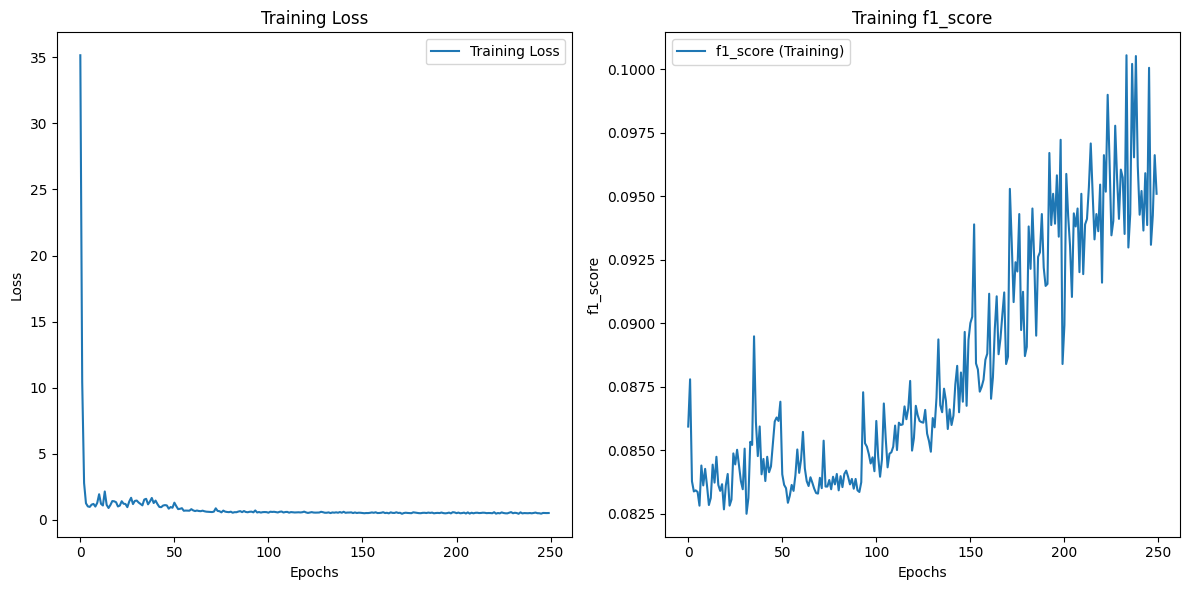

In [36]:
plt.figure(figsize=(12, 6))

#Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#AUC
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='f1_score (Training)')
plt.title('Training f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.tight_layout()
plt.show()

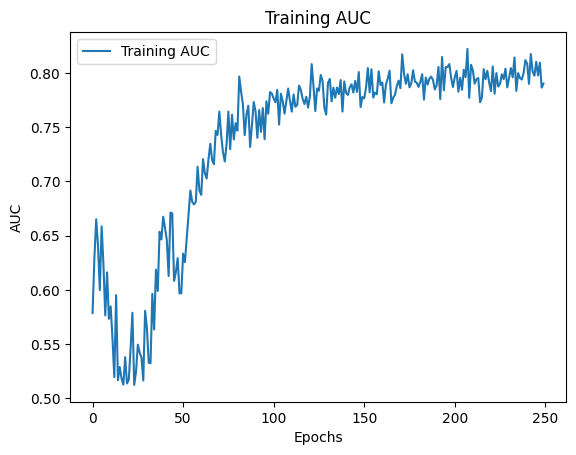

In [35]:
plt.plot(history.history['AUC'], label='Training AUC')
plt.title('Training AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

In [22]:
val_AUC, val_f1_score, val_loss = model.evaluate(features_test, task_test, verbose = 0)

print("Val loss: ", val_loss)
print("Val AUC: ", val_AUC)
print("Val f1: ", val_f1_score)

Val loss:  0.07802339643239975
Val AUC:  0.4807680547237396
Val f1:  0.7842237949371338


In [23]:
e =[]
for index, item in enumerate(task_data['NR-AR']):
  if item == 1:
    e.append(index)

  if len(e) > 10:
    break

print(e)

[99, 111, 129, 166, 237, 245, 304, 333, 345, 355, 398]


In [29]:
print(task_data.iloc[[3000]].to_numpy())
print(task_data.iloc[[1984]].to_numpy())

print(task_data.iloc[[1987]].to_numpy())
print(task_data.iloc[[398]].to_numpy())


[[1]]
[[0]]
[[0]]
[[1]]


In [30]:
test_input = feature_data.iloc[[3000]].to_numpy()
print(model.predict(test_input))

test_input = feature_data.iloc[[1984]].to_numpy()
print(model.predict(test_input))


test_input = feature_data.iloc[[1987]].to_numpy()
print(model.predict(test_input))

test_input = feature_data.iloc[[398]].to_numpy()
print(model.predict(test_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[[0.9851508]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.09261736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.12938853]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[0.61320466]]


# **Save the Model**

In [31]:
# assign location
path='/content/weights.weights.h5'

model.save(path)
print('Model Saved!')

Model Saved!


In [32]:
from tensorflow.keras.models import load_model


# load model
savedModel=load_model(path)
savedModel.summary()

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 64)                  │          14,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,643 (65.02 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)